
## Introduction and Motivation

This project explores the use of Cellular Automata (CA) for dimensionality reduction and embedding generation,
aiming to provide a flexible and explainable approach for creating embeddings suitable for various machine learning tasks.
The potential of CA lies in its simplicity and the complex behaviors it can exhibit, which we harness to generate meaningful lower-dimensional representations of data.



## Overview of Cellular Automata (CA) Transformation

Cellular Automata (CA) are discrete, computational systems that evolve through iterations based on simple rules applied to local neighborhoods.
In the context of dimensionality reduction, CA offers a unique approach by applying transformation rules to data, resulting in compressed representations. For unidimensional CA this can be achieved by relaxing the requirement that the number of cells should remain constant from iteration to iteration by skipping the state calculation for cells that are less than within the neighborhood window from the end of the current cell vector. The key to CA's flexibility in embedding generation lies in the ability to change the transformation function, allowing for tailored embeddings based on specific data characteristics or tasks.



## Function Definitions

- `ca_transform`: Transforms an input list to a lower-dimensional representation using CA. Parameters include `g` (dimensions to keep), `k` (neighborhood size), and the transformation `function`.

- `revert_ca_emb`: Attempts to reconstruct the original data from CA-transformed data, evaluating the transformation's effectiveness through reconstruction error.

- `test_ca_embed`: Tests various configurations of CA parameters to explore different embeddings' effectiveness and applicability.

- `ca_transform_matrix`: Extends `ca_transform` to handle matrices, allowing for batch processing of data vectors and enhancing the method's applicability.



## Reconstruction Using Linear Models

Exploration of linear models (`LinearRegression`, `Ridge`, `Lasso`) for reconstructing original data from CA-based embeddings highlights the challenges in linearly modeling complex CA transformations.
Regularization (L2/Ridge, L1/Lasso) is explored as a means to improve reconstruction quality by penalizing complexity, addressing overfitting, and potentially capturing more nuanced patterns in the data.



## Testing and Evaluation

The methodology involves assessing the reconstruction quality of CA-based embeddings using linear models, with attention to the effects of regularization.
The process reveals insights into the lossy nature of CA transformations and the inherent challenges posed by non-linear transformations, guiding future explorations towards more complex models for better reconstruction.



## Conclusion and Future Directions

Findings suggest CA's potential viability for dimensionality reduction, with potential areas for further research including non-linear models for reconstruction and applicability of the resulting vectors.
Future work will focus on testing the applicability of CA-based embeddings across different data types and machine learning tasks.

# Known limitations:
 - Order of values in the input vector matters - different orderings will produce different results using the described approach.
 - Some numbers of dimensions cannot be obtained while having specific combination of neighborhood size (k) and size of the input vector due to exclusion of exactly k-1 dimensions at every iteration.
 - Initial vectors are most probably not linearly reconstructable (as shown by attempting to map input vectors to low-dimensional representations using linear regression models), making the procedure irreversible.
 - Choice of the function (rule), as well as number of dimensions (g) and neighborhood size (k) should most probably be guided by an experiment and based on the type of data and the machine learning task at hand.

# Notes
 - There is a subtle similarity to time series smoothing approaches, for example [this one](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/how-time-series-smoothing-works.htm#:~:text=Time%20series%20smoothing%20techniques%20are,noise%20and%20short%2Dterm%20fluctuations). Perhaps it can make sense to try it on time series data.

In [1]:
import random
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.exceptions import ConvergenceWarning
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
def ca_transform(input_list, g=3, k=2, function=lambda x: max(x)):
    """
    Transform the input list to a lower-dimensional representation using a CA-like method.
    
    Parameters:
    - input_list: The list of numbers to be transformed.
    - g: The number of dimensions to keep in the final output.
    - k: The neighborhood size for the CA transformation.
    
    Returns:
    - A lower-dimensional representation of the input list.
    """
    if k <= 1:
        print('Please set k > 1. Using k+1 instead.')
        k += 1
    
    # Maximum number of steps to get to not less than g dimensions in the final vector
    m = (len(input_list) - g) / (k - 1)

    # Stop condition criterion
    step_counter = 0
    
    # To avoid overwriting input variable
    numbers = input_list.copy()
    # Stack to hold computations
    new_numbers = []
    
    while True:
        step_counter += 1
        # If next step will count as more than allowed number of iterations
        if step_counter == int(m) + 1 or step_counter == len(input_list):
            break
        
        # Calculate next generation of cells using uni-dimensional sliding window approach with size k
        for i in range(len(numbers) - k + 1):
            # Save results
            new_numbers.append(function(numbers[i:i+k]))
        
        # Change the state of cells
        numbers = new_numbers
        
        # Empty temp storage
        new_numbers = []
    
    # Return reduced-dimensional representation of input vector
    return numbers

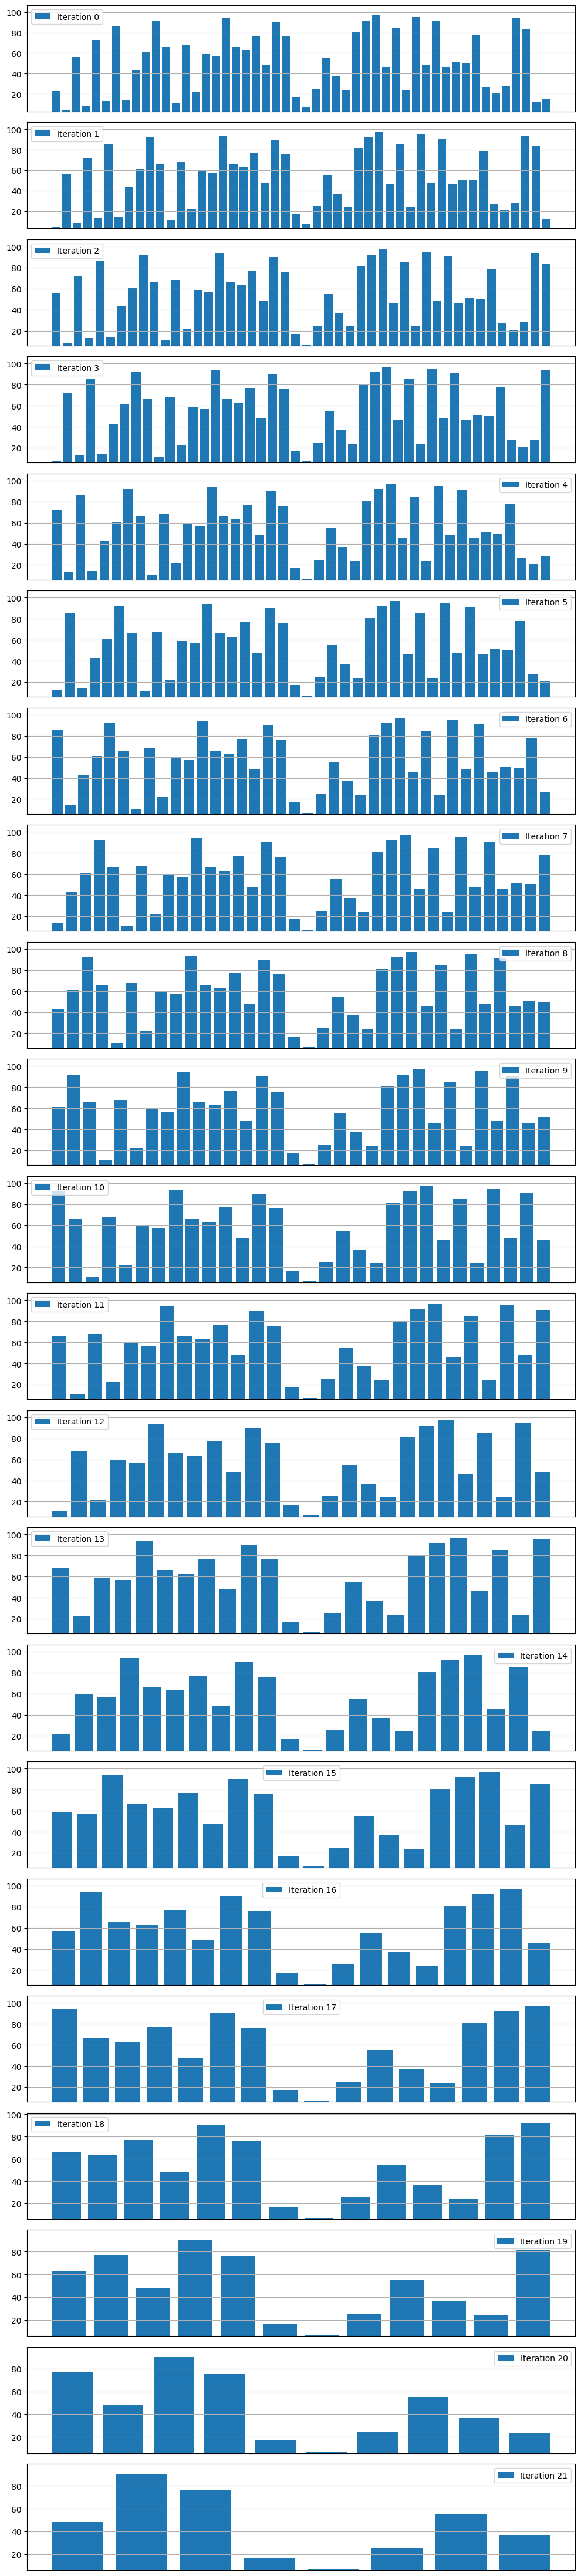

In [4]:
def visualize_ca_transform_values_bar(input_list, g=3, k=2, function=lambda x: x[1]): #sum(x)/(len(x)*max(x))
    '''Playground function to visualize changes of input vector during iterations'''
    iterations = []  # Store the vectors at each iteration
    iterations.append(input_list)  # Initial vector
    
    numbers = input_list.copy()
    new_numbers = []
    step_counter = 0
    m = (len(input_list) - g) / (k - 1)
    
    while True:
        step_counter += 1
        if step_counter == int(m) + 1 or step_counter == len(input_list):
            break
        
        for i in range(len(numbers) - k + 1):
            new_numbers.append(function(numbers[i:i+k]))
        
        iterations.append(new_numbers.copy())  # Store the vector for this iteration
        numbers = new_numbers
        new_numbers = []
    
    # Plotting
    plt.figure(figsize=(10, len(iterations) * 2))
    for idx, iteration in enumerate(iterations):
        plt.subplot(len(iterations), 1, idx + 1)
        plt.bar(range(len(iteration)), iteration, label=f'Iteration {idx}')
        plt.ylim(min(iteration) - 1, max(iteration) + 0.1*max(iteration))  # Adjust y-axis limits
        plt.legend()
        plt.xticks([])  # Remove x-tick labels
        plt.grid(True, axis='y')  # Only display grid lines for y-axis
    
    plt.tight_layout()
    plt.show()

# Example usage
input_list = [random.randint(0, 100) for _ in range(50)]
visualize_ca_transform_values_bar(input_list, g=7, k=3)

In [5]:

def revert_ca_emb(input, numbers):
   '''Attempt reverting the original vector from the transformed vector - works, but is not generalizable to matrices.'''
    # Assuming V_ca and V are already defined
   V_ca = np.array([numbers])  # Reduced-dimension representation
   V = np.array([input])      # Original vector
   # Solve for X
   X, _, _, _ = np.linalg.lstsq(V_ca, V, rcond=None)
   # Use X to reconstruct v from v_ca, demonstrating the solution
   v_reconstructed = np.dot(V_ca, X)
   # Calculate reconstruction error (MSE)
   reconstruction_error = np.mean((V - v_reconstructed) ** 2)
   #Checking the actual difference
   print(f'Original: {V}', f'Reconstructed: {v_reconstructed}', f'Embedding: {V_ca}',sep='\n')#, f'Transformation:\n{X}'
   print("Reconstruction Error:", reconstruction_error)

In [6]:
def test_ca_embed(input_size=10, function=lambda x: max(x)):
   '''Grid-like testing ca-embedding function with given input size and rule function'''
   for n in range(2,(input_size-2)//2):
      for j in range(2,11):
         try:
            print(n,j)
            input = [random.randint(0,100) for _ in range(input_size)]
            numbers = ca_transform(input_list=input, k=n, g=j, function=function)
            revert_ca_emb(input, numbers)
         except Exception as e:
            print(n, j, e)

In [56]:
def ca_transform_matrix(input_matrix, g=3, k=2, function=lambda x: max(x)):
    """
    Transform each vector in the input matrix to a lower-dimensional representation using a CA-like method.
    
    Parameters:
    - input_matrix: A NumPy array where each row is a vector to be transformed.
    - g: The number of dimensions to keep for each vector in the final output.
    - k: The neighborhood size for the CA transformation.
    - function: The function applied to each neighborhood.
    
    Returns:
    - A NumPy array of lower-dimensional representations for each input vector.
    """
    transformed_vectors = []
    for input_list in input_matrix:
        # The transformation logic remains the same, applied per vector
        new_numbers = []
        numbers = input_list.copy()
        step_counter = 0
        m = (len(input_list) - g) / (k - 1)
        while True:
            step_counter += 1
            if step_counter == int(m) + 1 or step_counter == len(input_list):
                break
            for i in range(len(numbers) - k + 1):
                new_numbers.append(function(numbers[i:i+k]))
            numbers = new_numbers
            new_numbers = []
        transformed_vectors.append(numbers)
    
    return np.array(transformed_vectors)

In [57]:
def revert_ca_matrix_emb(input_matrix, transformed_matrix):
    """
    Attempt to reconstruct the original matrix from the transformed matrix using least squares.
    
    Parameters:
    - input_matrix: The original matrix of vectors.
    - transformed_matrix: The matrix of transformed vectors.
    
    Returns:
    - Reconstruction error for the matrix.
    """
    # Ensure matrices are two-dimensional
    V_ca = transformed_matrix
    V = input_matrix
    print(V_ca.shape)
    print(V.shape)
    # Solve for X using least squares for each vector
    X, _, _, _ = np.linalg.lstsq(V_ca, V, rcond=None)  # Transpose to match dimensions
    
    # Reconstruct original matrix
    V_reconstructed = np.dot(V_ca, X)  # Transpose back after reconstruction
    # Calculate reconstruction error (MSE)
    reconstruction_error = np.mean((V - V_reconstructed) ** 2)
    print("Reconstruction Error:", reconstruction_error)
    #Checking the actual difference
    print(f'Original: {V}', f'Reconstructed: {V_reconstructed}', f'Embedding: {V_ca}', f'Transformation:\n{X}',sep='\n'), 
    print("Reconstruction Error:", reconstruction_error)
    return reconstruction_error

In [58]:
def reconstruct_with_sklearn(input_matrix, transformed_matrix, regularizer=None, alpha=1.0):
    """
    Reconstruct the original matrix from the transformed matrix using sklearn linear models,
    and return the reconstruction error along with the model's parameters.
    
    Parameters:
    - input_matrix: The original matrix of vectors.
    - transformed_matrix: The matrix of transformed vectors.
    - regularizer: The type of regularization to apply ('None', 'L2', or 'L1').
    - alpha: The regularization strength (applies only if a regularizer is selected).
    
    Returns:
    - Reconstruction error for the matrix.
    - Model coefficients (X matrix).
    - Model intercept.
    """
    # Select the model based on the regularizer option
    if regularizer == 'L2':
        model = Ridge(alpha=alpha)
    elif regularizer == 'L1':
        model = Lasso(alpha=alpha)
    else:  # Default to LinearRegression (no regularization)
        model = LinearRegression()
    
    # Fit the model to the transformed matrix and original matrix
    model.fit(transformed_matrix, input_matrix)
    
    # Predict/Reconstruct the original matrix
    V_reconstructed = model.predict(transformed_matrix)
    
    # Calculate reconstruction error (MSE)
    reconstruction_error = np.mean((input_matrix - V_reconstructed) ** 2)
    print(f"Reconstruction Error with {regularizer if regularizer else 'None'} Regularization:", reconstruction_error)
    print(f'Original:\n{input_matrix}', f'Reconstructed:\n{V_reconstructed}', f'Embedding:\n{transformed_matrix}', f'A:\n{model.coef_}', f'B:\n{model.intercept_}',sep='\n', ), 
    
    # Return the reconstruction error, model coefficients (X matrix), and intercept
    return reconstruction_error, model.coef_, model.intercept_

In [59]:
def test_ca_transform_matrix_and_revert(input_size=10, function=lambda x: max(x)):
    '''Attempting to reconstruct the original matrix using linear regression models'''
    # Generate a matrix of random vectors
    input_matrix = np.array([random.sample(range(100), 10) for _ in range(input_size)])  # Example: 5 vectors of length 10
    for n in range(2,(input_size-2)//2):
      for j in range(2,input_size - 1):
         # Transform the matrix
         g = j  # Number of dimensions to keep
         k = n  # Neighborhood size
         try:
            print(f'Testing with k = {k}, g = {g}, number of columns = {input_size}')
            transformed_matrix = ca_transform_matrix(input_matrix, g, k, function=function)
            # Attempt to reconstruct the original matrix from the transformed matrix
            reconstruct_with_sklearn(input_matrix, transformed_matrix)
            reconstruct_with_sklearn(input_matrix, transformed_matrix, regularizer='L1')
            reconstruct_with_sklearn(input_matrix, transformed_matrix, regularizer='L2')
         except Exception as e:
            print(n, j, e)

In [60]:
if __name__ == "__main__":
  test_ca_transform_matrix_and_revert()

Testing with k = 2, g = 2, number of columns = 10
Reconstruction Error with None Regularization: 575.3056635802468
Original:
[[25 88 37 22 18 64 68 60 29  3]
 [76 10 73 83  7 12 96 21  0 23]
 [55  5 83 92 90 81 53 46 42 69]
 [57 25  0 98 18 24 72 50  7 36]
 [43 67 91 94 58 13 38 48 62 24]
 [69 80 78 95 51 90 70  4 75  5]
 [78 79 39 55 87 70 45 72 33 86]
 [ 4 94 86 34 49 44 63 18 70 53]
 [37 82 70 51 41 69 53 88 64  0]
 [10 77 90 57 20 22 27 59 63 14]]
Reconstructed:
[[38.97685185 80.09259259 66.39814815 47.23611111 53.48611111 63.41203704
  47.22222222 67.18518519 51.66203704 33.10185185]
 [51.21141975 43.15432099 63.16358025 86.97685185 35.22685185 35.77006173
  68.7037037  27.97530864 38.02006173 29.66975309]
 [45.0941358  61.62345679 64.7808642  67.10648148 44.35648148 49.59104938
  57.96296296 47.58024691 44.84104938 31.38580247]
 [54.27006173 33.91975309 62.35493827 96.91203704 30.66203704 28.8595679
  74.07407407 18.17283951 34.6095679  28.8117284 ]
 [48.15277778 52.38888889 63.9